In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from typing import Tuple, List, Dict, Any
from pathlib import Path

#set seeds
np.random.seed(42)


In [10]:
df = pd.read_csv("data/japan_n_skorea.csv")

In [11]:
def save_fig(fig, name)-> None:
    """
    Save the figure to the specified path.
    
    :param name: A string representing the name of the figure.
    :param fig: A matplotlib figure object.
    :return: None
    """
    cwd = Path.cwd()
    path = cwd / "figures" / f"{name}.png"
    if not path.parent.exists(): path.parent.mkdir(parents=True)
    fig.savefig(path)
    
    

def time_difference(time: pd.Series) -> pd.Series:
    """
    Calculate the time difference between the current time and the next time.
    
    :param time: A pandas Series of datetime values.
    :return: A pandas Series of time differences.
    """
    time_diff = time - time.shift(1)
    return time_diff

def process_time(time: pd.Series) -> pd.Series:
    """
    Process the time series data by converting to datetime, sorting, and calculating time differences.
    
    :param time: A pandas Series of datetime values.
    :return: A pandas Series of time differences in seconds.
    """
    time = pd.to_datetime(time)
    time = time.sort_values()
    dt = time_difference(time)
    dt = dt.dt.total_seconds()
    dt = dt[dt > 0].reset_index(drop=True)
    return dt

def analyze_distributions(in_series: pd.Series, significance: float = 0.05) -> Tuple[List[List[Any]], Dict[str, Dict[str, float]]]:
    """
    Analyze the distribution of the data and test for goodness of fit.
    
    :param in_series: A pandas Series of time differences.
    :param significance: Significance level for the goodness of fit tests.
    :return: A tuple containing the results of the analysis and the output parameters.
    """
    results = []
    output_parameters = {}

    # Uniform distribution
    fit_uniform_dist = stats.uniform(loc=(in_series.min()), scale=in_series.max() - in_series.min())
    test = stats.kstest(in_series, fit_uniform_dist.cdf)
    p_value = test[1]
    fit_status = "Good fit" if p_value > significance else "Bad fit"
    results.append(["Uniform Distribution", fit_status, p_value])
    output_parameters["Uniform Distribution"] = {
        "loc": in_series.min(),
        "scale": in_series.max() - in_series.min()
    }

    # Exponential distribution
    m1 = np.mean(in_series)
    fit_exponential_dist = stats.expon(scale=1 / m1)
    test = stats.kstest(in_series, fit_exponential_dist.cdf)
    p_value = test[1]
    fit_status = "Good fit" if p_value > significance else "Bad fit"
    results.append(["Exponential Distribution", fit_status, p_value])
    output_parameters["Exponential Distribution"] = {
        "estimated_lambda": 1 / m1
    }

    # Gamma distribution
    m2 = np.mean([x ** 2 for x in in_series])
    est_beta = m1 / (m2 - m1 ** 2)
    est_alpha = m1 * est_beta
    fit_gamma_dist = stats.gamma(a=est_alpha, scale=1 / est_beta)
    test = stats.kstest(in_series, fit_gamma_dist.cdf)
    p_value = test[1]
    fit_status = "Good fit" if p_value > significance else "Bad fit"
    results.append(["Gamma Distribution", fit_status, p_value])
    output_parameters["Gamma Distribution"] = {
        "estimated_alpha": est_alpha,
        "estimated_beta": est_beta
    }

    # Poisson distribution
    fi_poisson_dist = stats.poisson(mu=m1)
    test = stats.kstest(in_series, fi_poisson_dist.cdf)
    p_value = test[1]
    fit_status = "Good fit" if p_value > significance else "Bad fit"
    results.append(["Poisson Distribution", fit_status, p_value])
    output_parameters["Poisson Distribution"] = {
        "estimated_lambda": m1
    }

    # Normal distribution
    estimated_std = m2 - m1 ** 2
    fit_normal_dist = stats.norm(loc=m1, scale=estimated_std)
    test = stats.kstest(in_series, fit_normal_dist.cdf)
    p_value = test[1]
    fit_status = "Good fit" if p_value > significance else "Bad fit"
    results.append(["Normal Distribution", fit_status, np.format_float_scientific(test[1], precision=2)])
    output_parameters["Normal Distribution"] = {
        "estimated_mean": m1,
        "estimated_std": estimated_std
    }
    return results, output_parameters



def generate_qq_plot(in_series: pd.Series, output_parameters: Dict[str, Dict[str, float]], case:str) -> None:
    """
    Generate a Q-Q plot of the data against the fitted distribution.
    :param in_series: input time series data
    :param output_parameters: parameters of the fitted distributions
    :param case: A string representing the case of earthquakes to analyze.
    :return: 
    """
    
    uniform_dist = stats.uniform(loc=output_parameters["Uniform Distribution"]["loc"], scale=output_parameters["Uniform Distribution"]["scale"])
    exp_dist = stats.expon(scale=1 / output_parameters["Exponential Distribution"]["estimated_lambda"])
    gamma_dist = stats.gamma(a=output_parameters["Gamma Distribution"]["estimated_alpha"], scale=1 / output_parameters["Gamma Distribution"]["estimated_beta"])
    poisson_dist = stats.poisson(mu=output_parameters["Poisson Distribution"]["estimated_lambda"])
    normal_dist = stats.norm(loc=output_parameters["Normal Distribution"]["estimated_mean"], scale=output_parameters["Normal Distribution"]["estimated_std"])

    
    distributions= [exp_dist, gamma_dist, normal_dist, poisson_dist, uniform_dist]
    names = ["Exponential", "Gamma", "Normal", "Poisson", "Uniform"]
    fig, ax = plt.subplots(nrows=len(distributions), ncols=1, figsize=(10, 5*(len(distributions)+1)))
    for i, dist in enumerate(distributions):
        stats.probplot(in_series, dist=dist, plot=ax[i])
        ax[i].set_title(f"Q-Q Plot of {names[i]}")
        ax[i].set_xlabel(f"Theoretical Quantiles ({names[i]})")
        ax[i].set_ylabel(f"Sample Quantiles")
        
    
    plt.suptitle(f"Q-Q Plot of Inter-Arrival Time of {case} Earthquakes vs Theoretical Distributions", fontsize=16)
    save_fig(fig, f"qq_plot_{case}")
    plt.show()
    
    

    

def overlay_distribution_plot(in_series: pd.Series, output_parameters: Dict[str, Dict[str, float]], case:str) -> None:
    """
    Overlay the distribution plots of the fitted distributions and the data.
    
    :param in_series: A pandas Series of time differences.
    :param output_parameters: A dictionary of output parameters for the fitted distributions.
    :param case: A string representing the case of earthquakes to analyze.
    :return: None
    """
    n = len(in_series)
    exp_dist = np.random.exponential(output_parameters["Exponential Distribution"]["estimated_lambda"], n)
    gamma_dist = np.random.gamma(output_parameters["Gamma Distribution"]["estimated_alpha"],1 / output_parameters["Gamma Distribution"]["estimated_beta"],n)
    normal_dist = np.random.normal(output_parameters["Normal Distribution"]["estimated_mean"], output_parameters["Normal Distribution"]["estimated_std"],n)
    poisson_dist = np.random.poisson(output_parameters["Poisson Distribution"]["estimated_lambda"], n)
    uniform_dist = np.random.uniform(output_parameters["Uniform Distribution"]["loc"],output_parameters["Uniform Distribution"]["scale"],n)
    
    distributions = [exp_dist, gamma_dist, normal_dist, poisson_dist, uniform_dist]
    names = ["Exponential", "Gamma", "Normal", "Poisson", "Uniform"]

    fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(10, 25))

    for i, dist in enumerate(distributions):
        sns.histplot(dist, kde=True, ax=ax[i])
        sns.histplot(in_series, kde=True, ax=ax[i])
        ax[i].legend(["Fitted Distribution", "Data"])
        ax[i].set_title(f"{names[i]} Distribution")
        ax[i].set_xlabel("Time Difference")
        ax[i].set_ylabel("Frequency")

    fig.suptitle(f"Overlay of the Distribution of Inter-Arrival Time of {case} Earthquakes with Theoretical Distributions  ", fontsize=16)
    
    save_fig(fig, f"overlay_dist_{case}")
    plt.show()

def main(data:pd.DataFrame, case:str) -> Tuple[List[List[Any]], Dict[str, Dict[str, float]]]:
    """
    Main function to process time series data, analyze distributions, and plot the results.
    
    :return: A tuple containing the results of the analysis and the output parameters.
    """
    cases = ["All", "Large", "Small"]
    assert case in cases, f"Invalid case. Choose from {cases}"
    
    time = None
    
    if case == "All":
        time = data["time"]
    elif case == "Large":
        time = data[data["mag"] > 5]["time"]
    elif case == "Small":
        time = data[data["mag"] < 5]["time"]
        

    dt = process_time(time)
    results, output_parameters = analyze_distributions(dt)
    overlay_distribution_plot(dt, output_parameters, case)
    generate_qq_plot(dt, output_parameters, case)
    return results, output_parameters

In [12]:
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2024-09-24T06:00:53.328Z,31.3961,140.0063,62.992,4.6,mb,40.0,134.0,4.664,0.89,...,2024-09-24T06:34:59.040Z,"Izu Islands, Japan region",earthquake,11.04,8.591,0.105,27.0,reviewed,us,us
1,2024-09-23T23:14:19.526Z,31.5463,140.0638,11.710,5.6,mww,110.0,86.0,1.579,1.07,...,2024-09-24T13:57:02.040Z,"Izu Islands, Japan region",earthquake,7.31,4.231,0.053,34.0,reviewed,us,us
2,2024-09-21T15:57:50.402Z,31.1565,140.9208,40.337,4.4,mb,67.0,132.0,2.167,0.54,...,2024-09-21T18:51:42.040Z,"Izu Islands, Japan region",earthquake,5.78,7.628,0.076,51.0,reviewed,us,us
3,2024-09-20T12:22:20.539Z,33.2622,132.2763,50.692,4.9,mb,75.0,56.0,1.416,0.92,...,2024-09-21T04:48:46.731Z,"26 km SW of Yawatahama, Japan",earthquake,5.90,6.386,0.038,225.0,reviewed,us,us
4,2024-09-19T09:18:10.282Z,35.6655,140.9251,43.764,4.6,mb,37.0,119.0,2.367,1.65,...,2024-09-19T11:13:06.040Z,"11 km SE of Hasaki, Japan",earthquake,7.18,7.662,0.105,27.0,reviewed,us,us


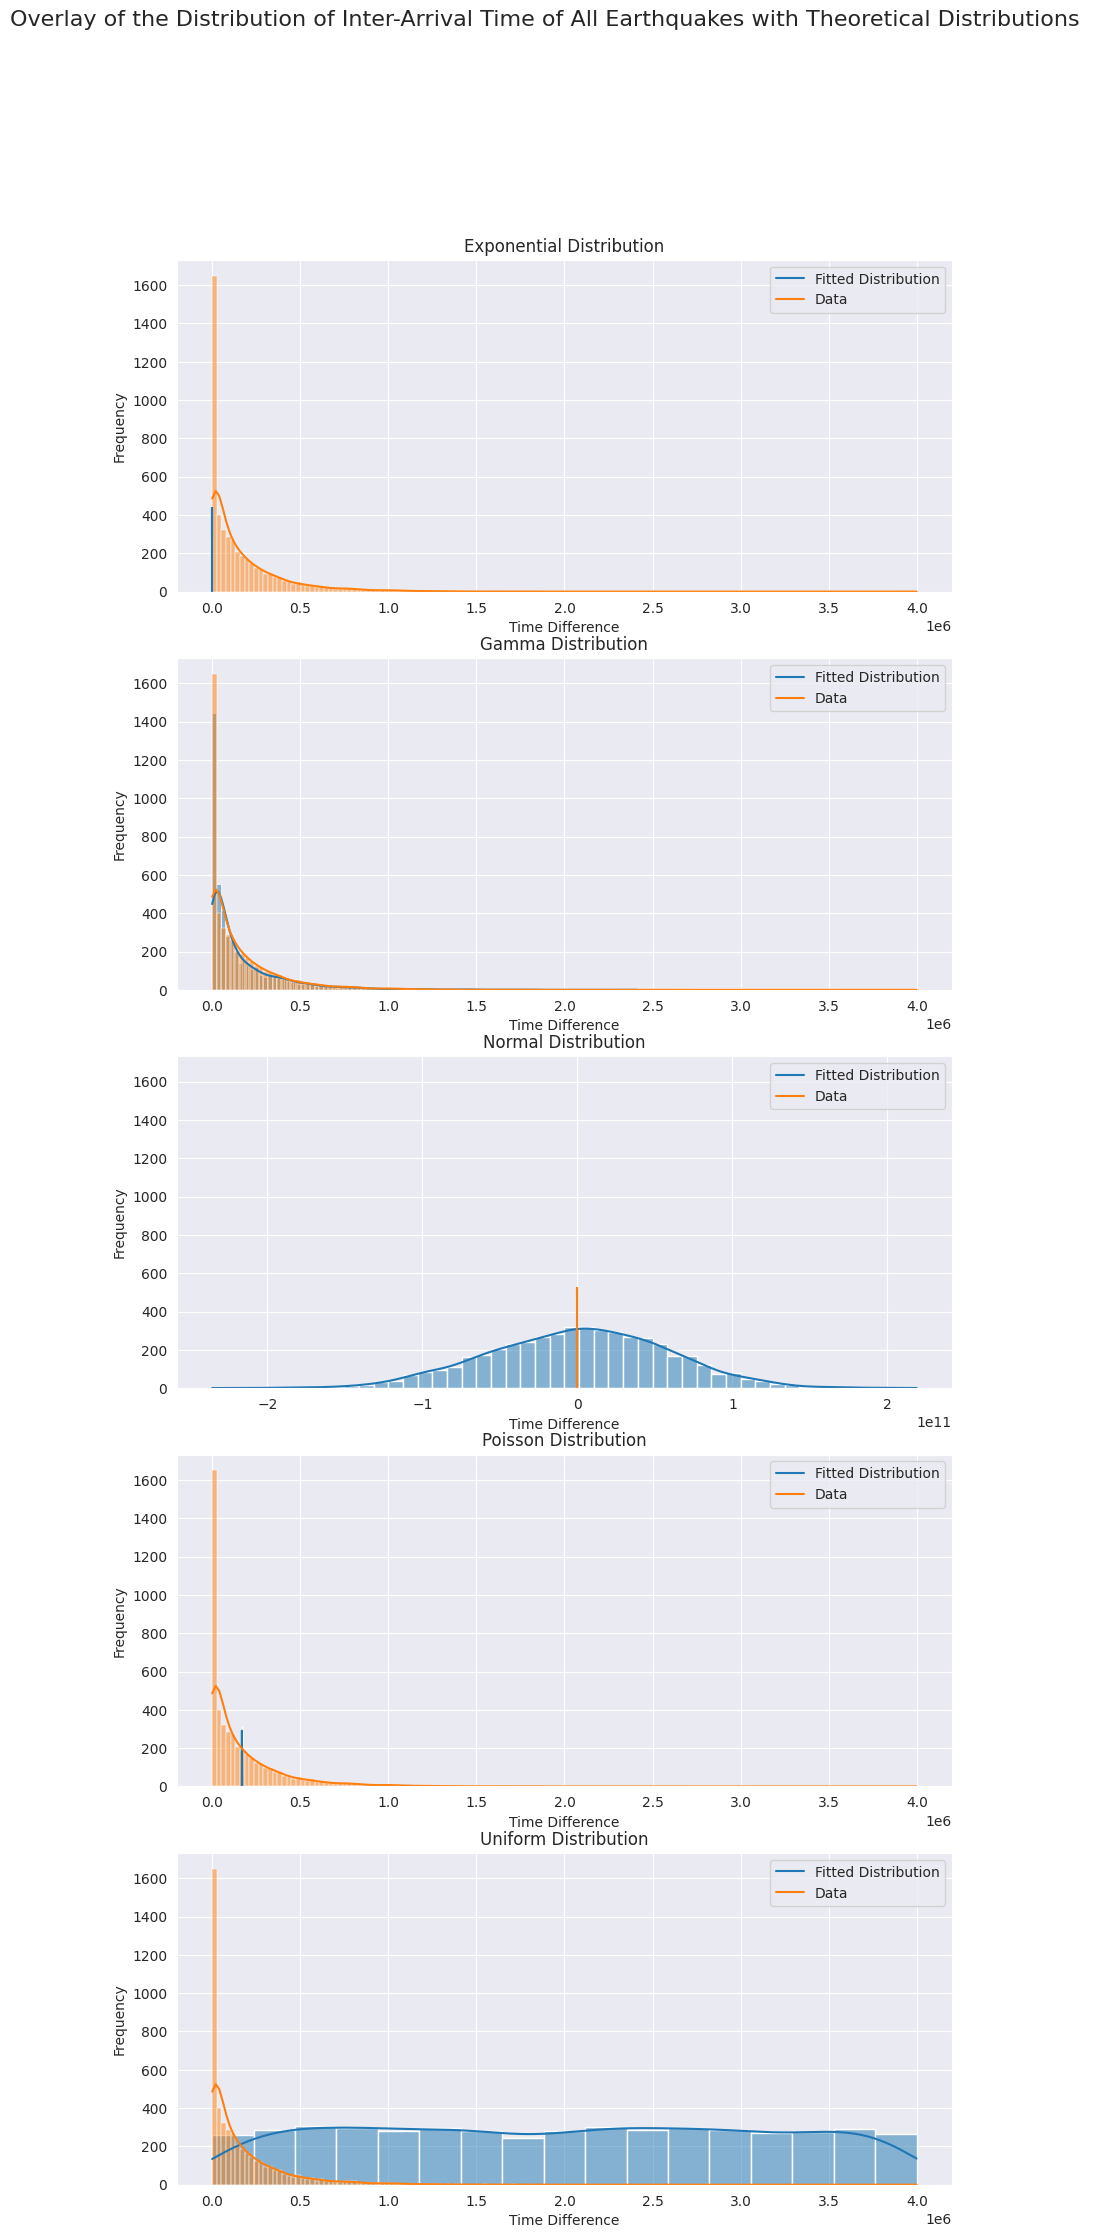

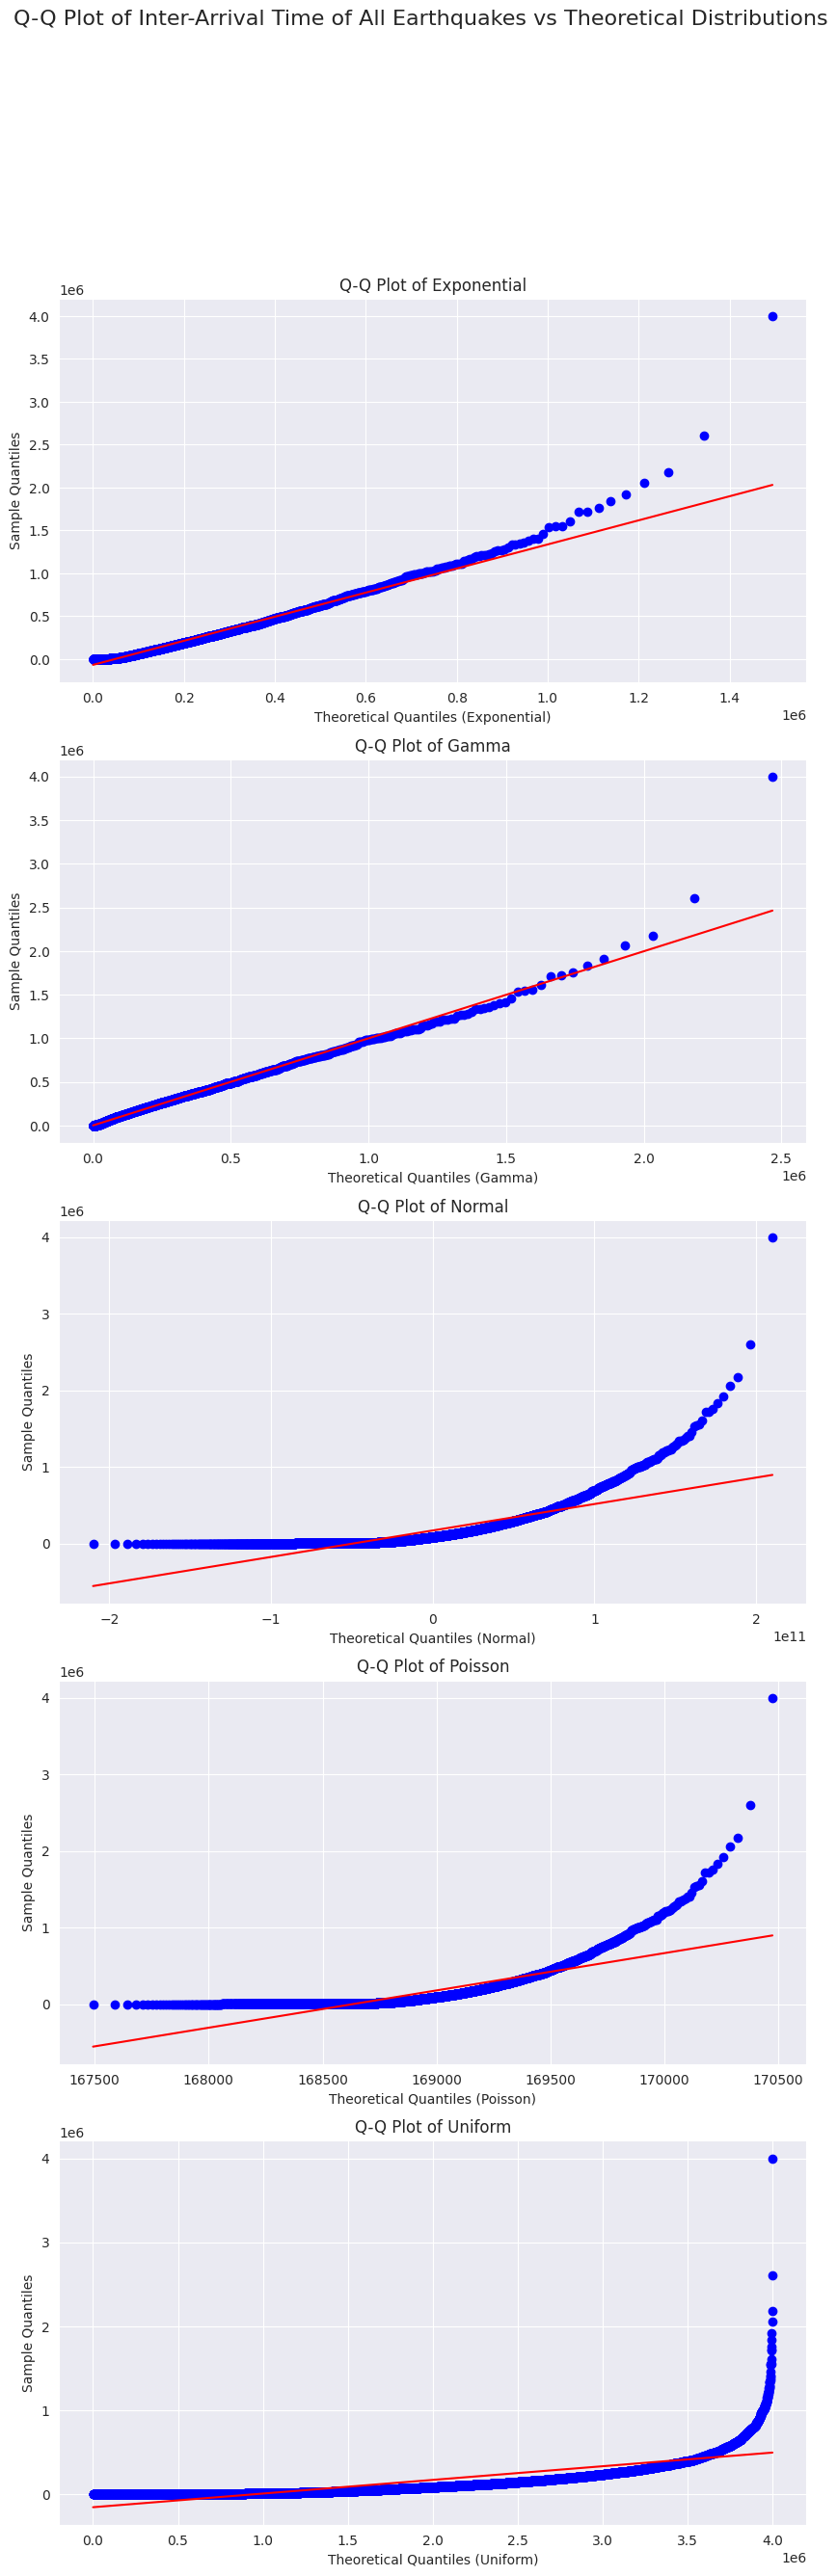

In [45]:

# all earthquake
results_all_eq, params_all_eq = main(df, "All")



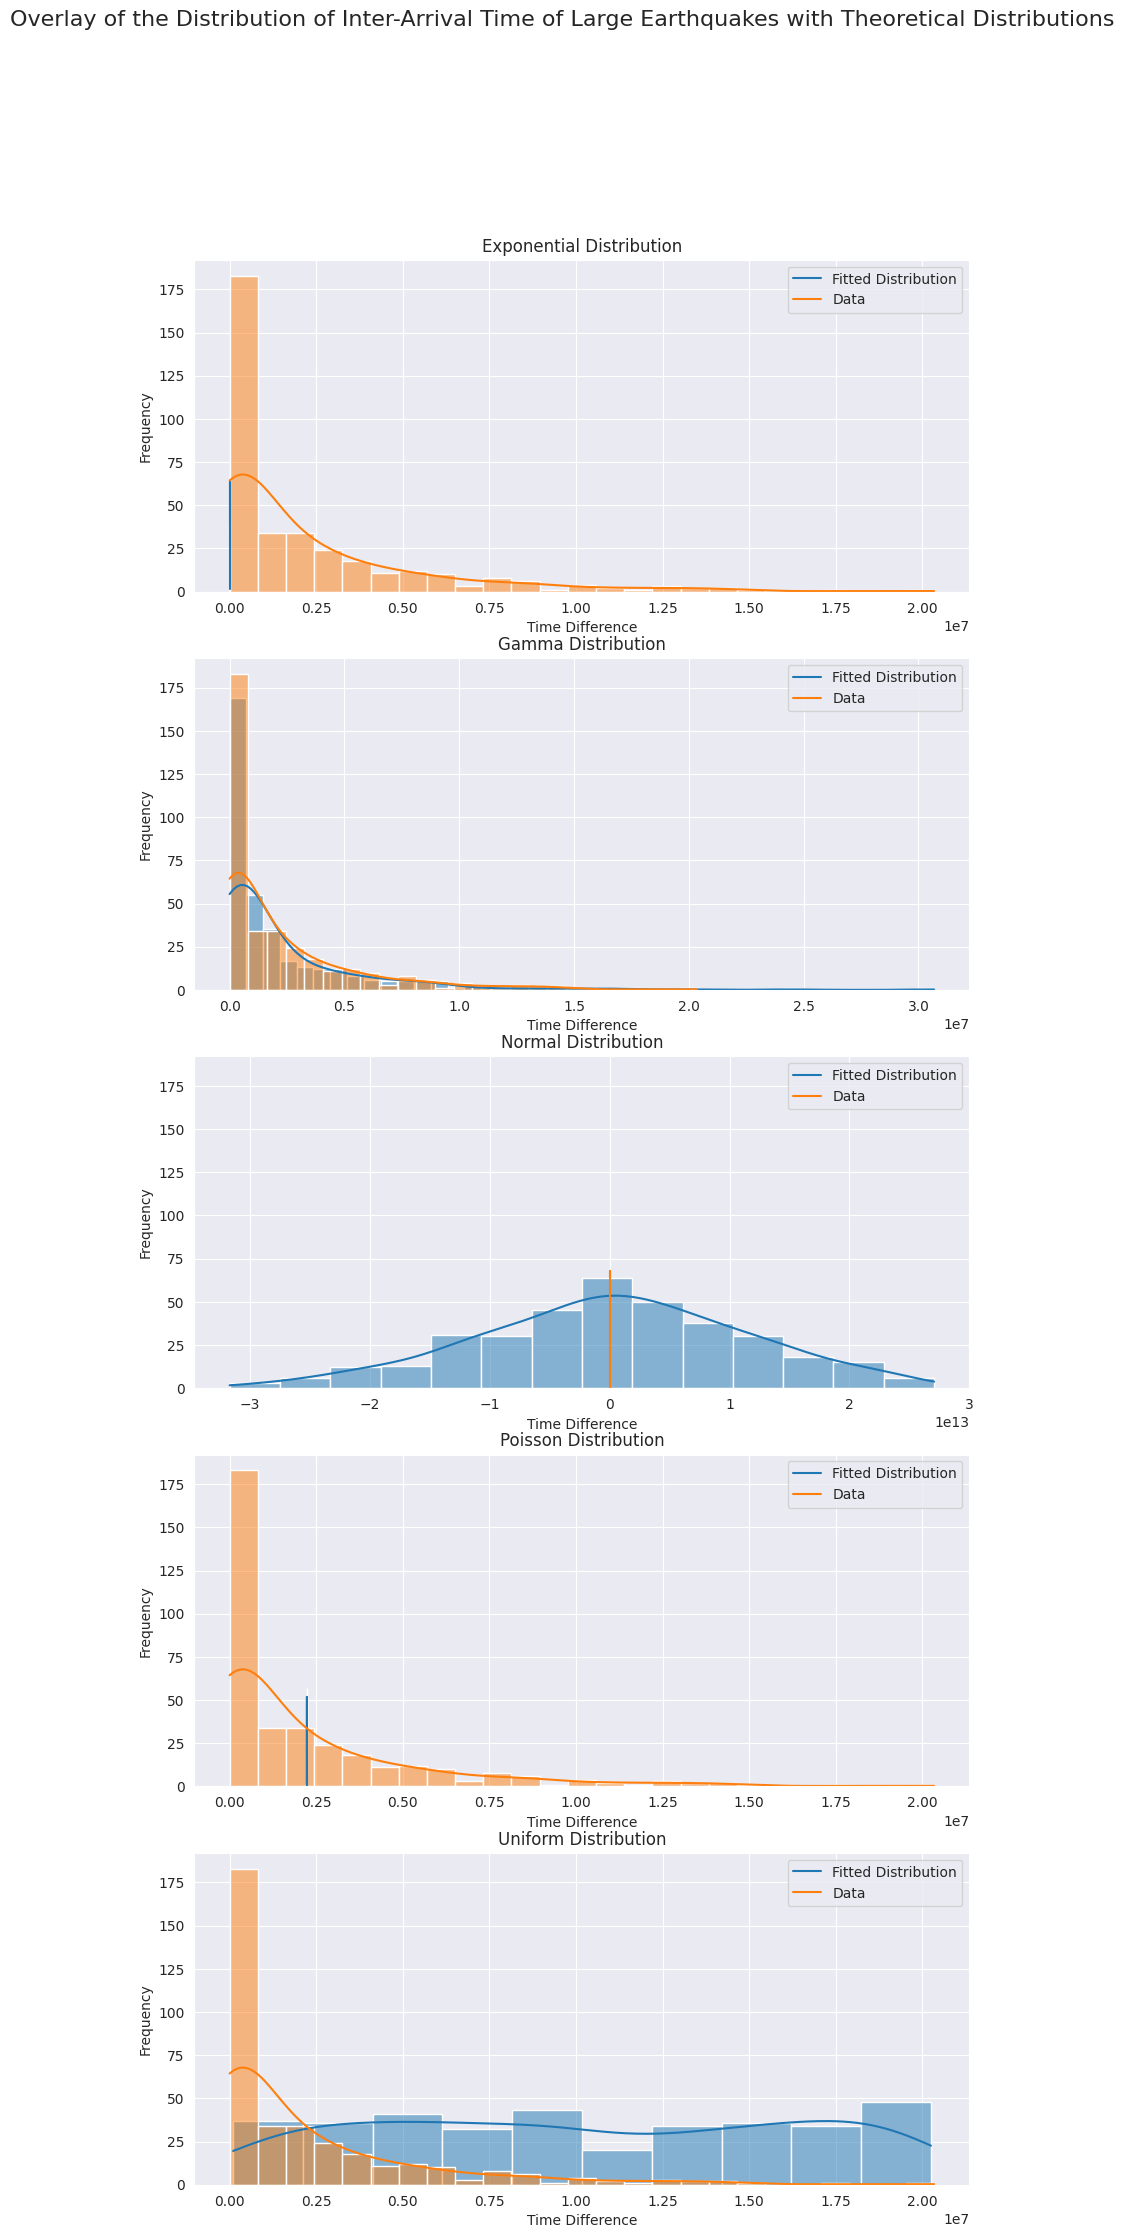

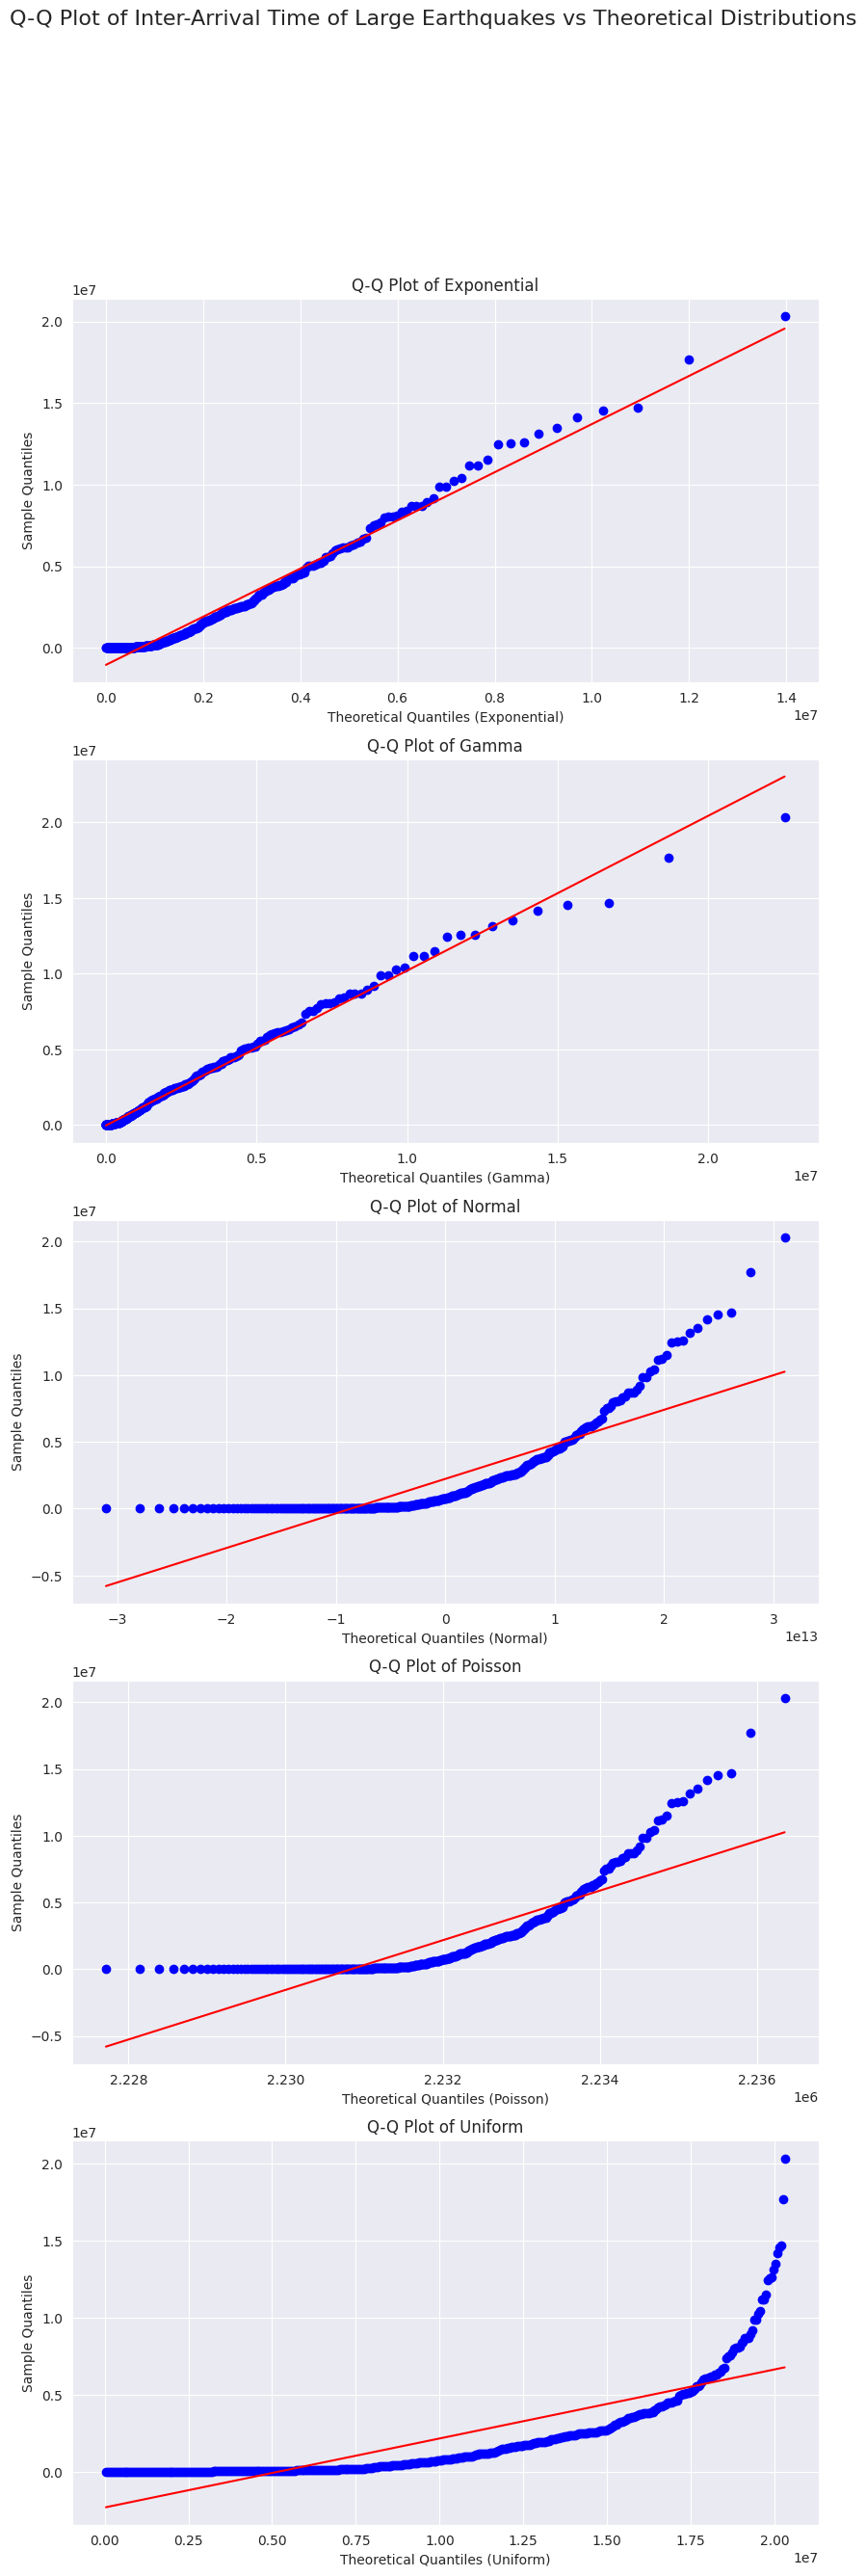

In [46]:

# Earthquakes with magnitude greater than 5
results_big_eq, params_big_eq = main(df, "Large")

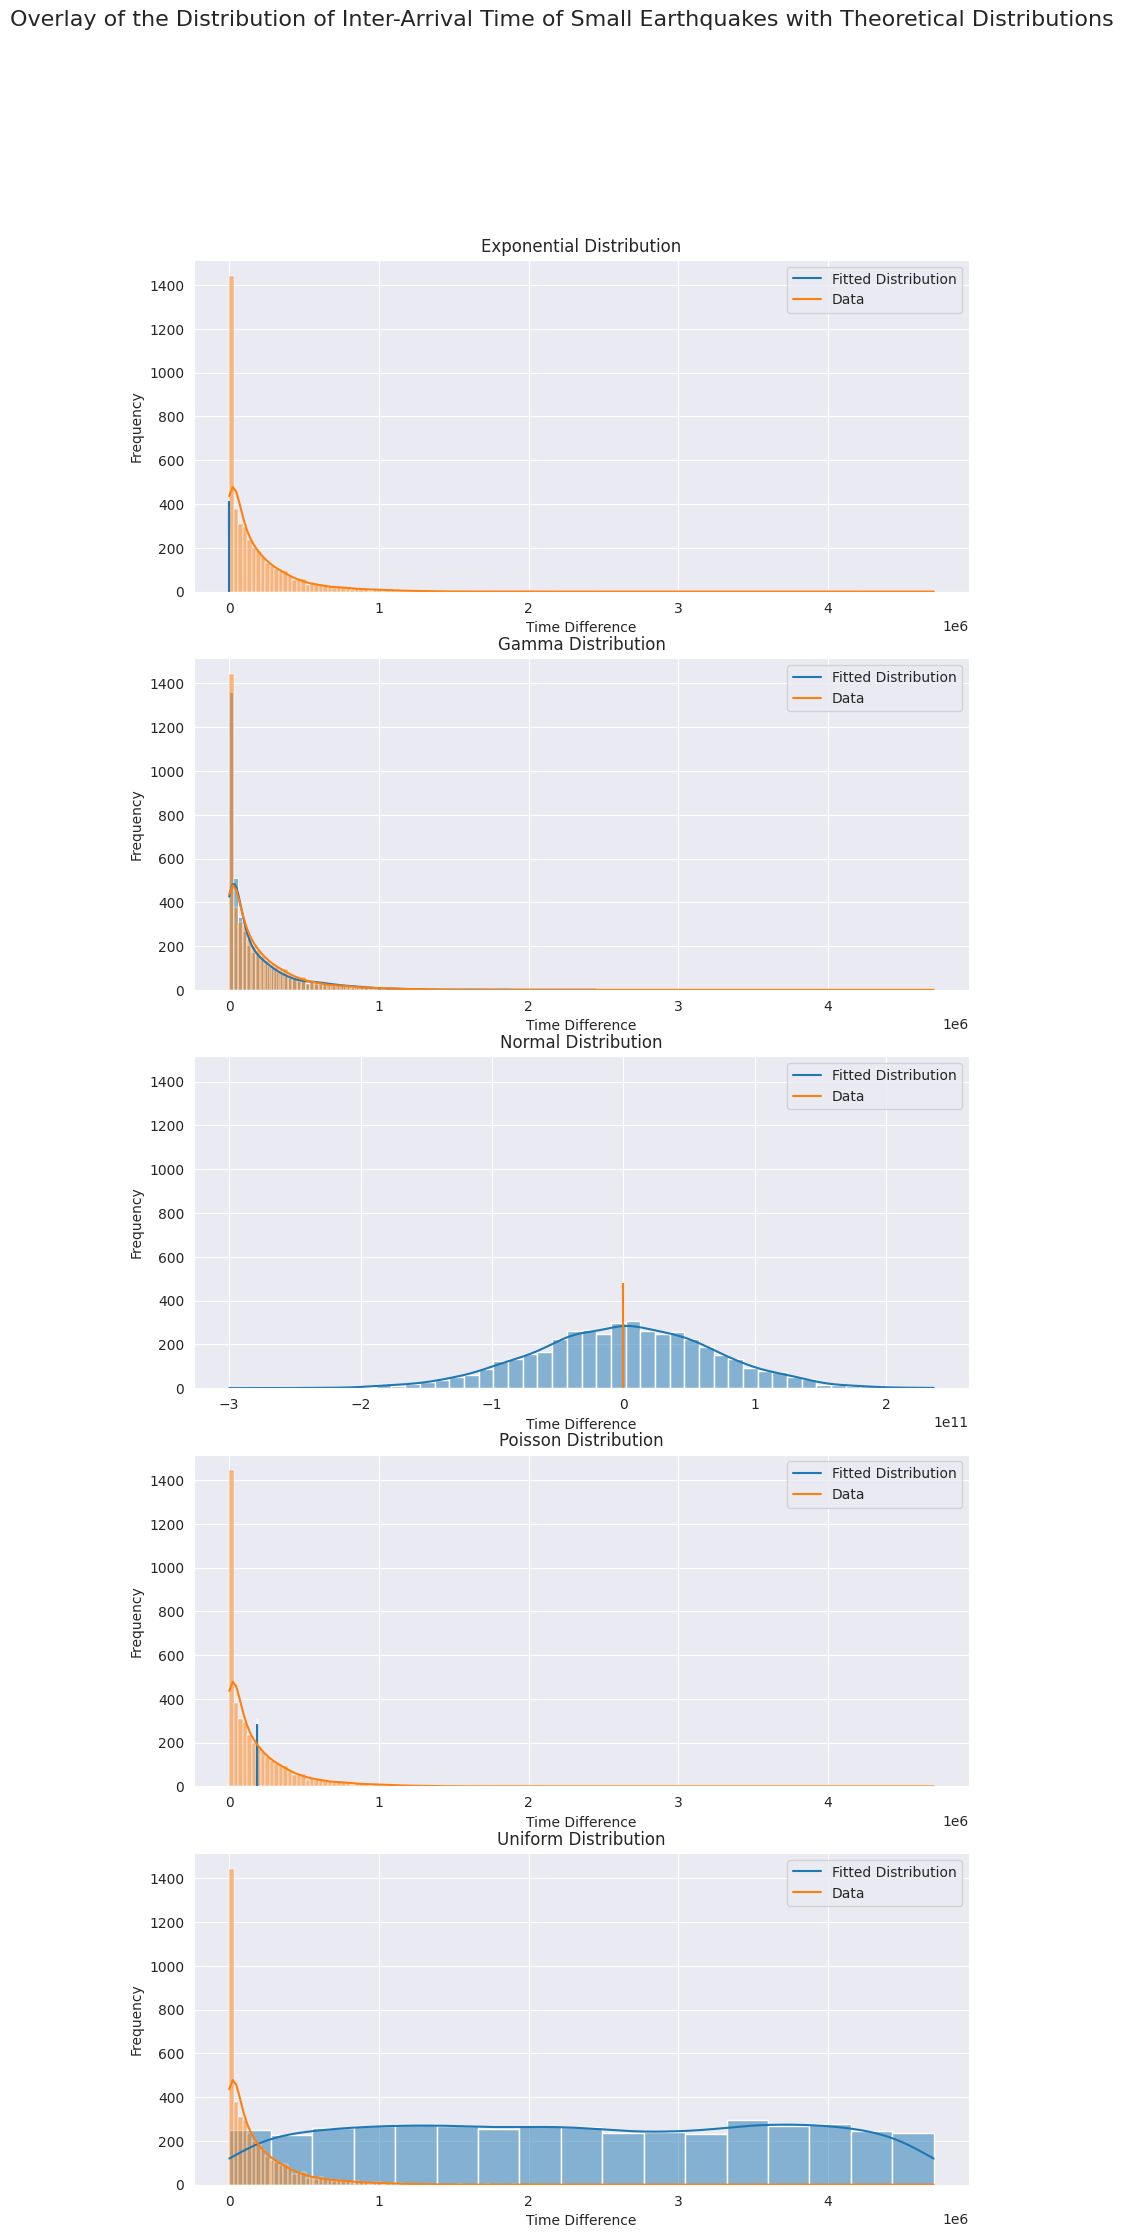

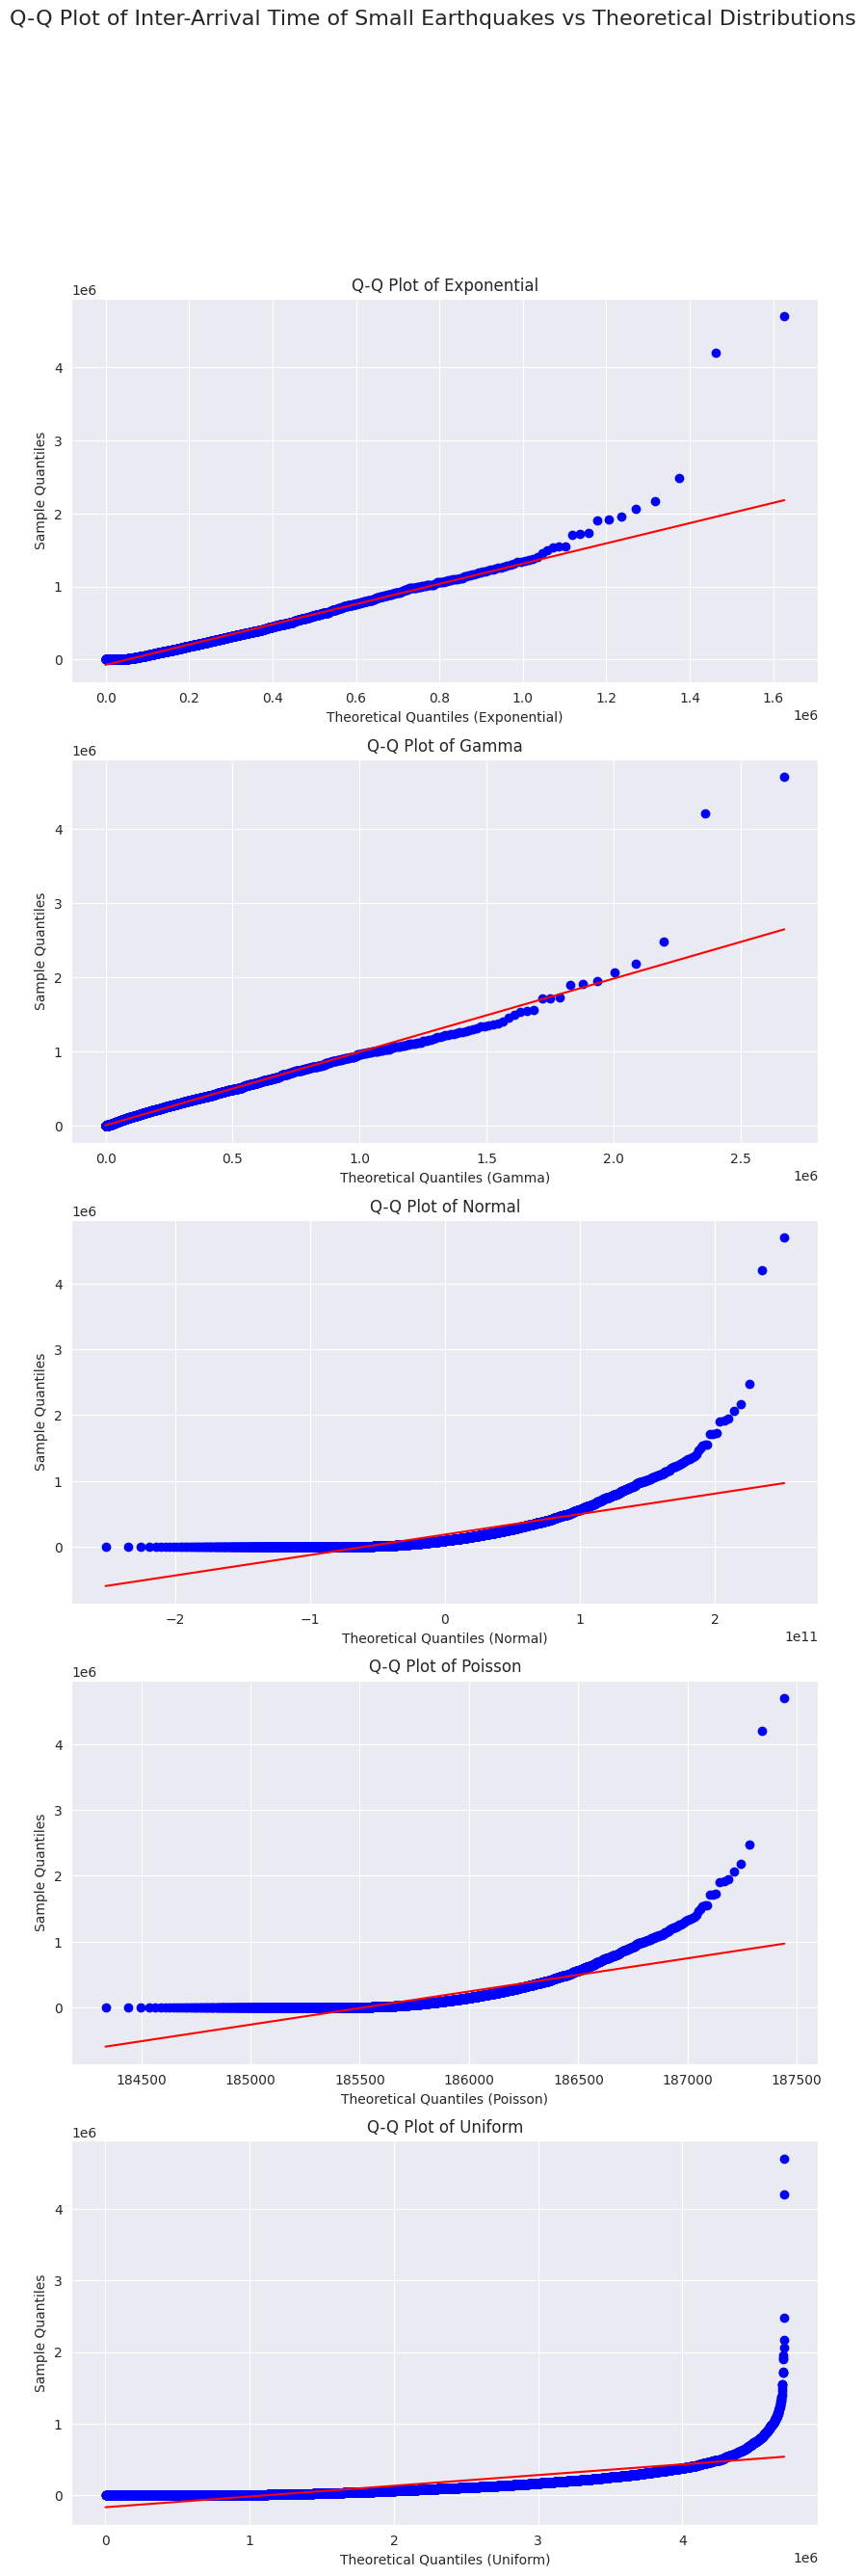

In [47]:

    
# Earthquakes with magnitude less than 5
results_sm_eq, params_sm_eq = main(df, "Small")
    
    
    
    
    
    
